# Etude de l'evolution de l'électrolyte dans une sturcture poreuse

---------------------------------------------------
Ce notebook rend compte de la modélisation de la vitesse et du temps de remplissage de l'electrolyte pour structures non-calendrées, en fonction de la configuration en un réseau de pores de cette même électrode. L'ensemble des données est issu de simulations $\textit{LBM}$ pré-traité sous Python.

------------------------------------------------------------
<br>
L'étude tient compte de l'analyse quantitative des données récoltées afin de construire une base de données permettant la modélisation via un réseau de neurones multi-couches, dit $\textit{Multi-Layers Perceptron}$
Le but est alors de pouvoir utiliser le modèle entrainé pour prédire la vitesse et temps de remplissage l'électrolyte pour des structures totalement nouvelles, évitant ainsi le calcule de simulations extrêmement couteuses en termes de ressources informatiques.

##### Ressources Python

In [1]:
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import initializers
import matplotlib.gridspec as gridspec
from sklearn.metrics import r2_score
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy import interpolate
from tensorflow import keras
from sklearn import metrics
import tensorflow as tf
import pandas as pd
import numpy as np
import warnings
import random
import pickle

warnings.filterwarnings("ignore")

##### Chargement des données nécessaires

In [75]:
with open('./Y.pkl', 'rb') as f:
    y = pickle.load(f)
with open('./données/X.pkl', 'rb') as f:
    X = pickle.load(f)

##### Transformation des données

In [76]:
X['Y0'] = y.iloc[:, 0]
X['Y1'] = y.iloc[:, 4]
X['Y2'] = y.iloc[:, 1]

idx=[]
for i in range(X.shape[0]):
    if "nan" != str(X.iloc[i,7]):
        idx.append(i)
X = X.iloc[idx, :]
X=X[X['Y1'] != "Error"]

In [77]:
old_version1, old_version2, old_version3 = X['Y1'].copy(), X['Y2'].copy(), X['Y0'].copy()

X['Y0'] = [np.log(i) for i in X['Y0']]
X['Y1'] = [np.log(i) for i in X['Y1']]
minval = min(X['Y1'])
X['Y1'] = [i+abs(minval) for i in X['Y1']]
X['Y2'] = [np.log(i) for i in X['Y2']]

La distribution des valeurs de sortie est hétéroscdastique, ce qui induit un biais dans la modélisation. Une transformation des données par le processus de $\textit{Box-Cox}$ [1] permet à la variable $V_0$, $t_0$ et $t_1$ d'être assimilée à une distribution plus homoscédastique. Cela permet à la modélisation de mieux assimiler les eccarts de sorties à faibles valeurs, qu'à hautes valeurs.
Cependant, la transformation pour la vélocité sera simplement shiftée à 0 afin de construire un réseau de neurones avec une fonction d'activation dite $\textit{LeakyReLU}$ en sortie, qui se révèle extrêment efficace lors de la prédiction.

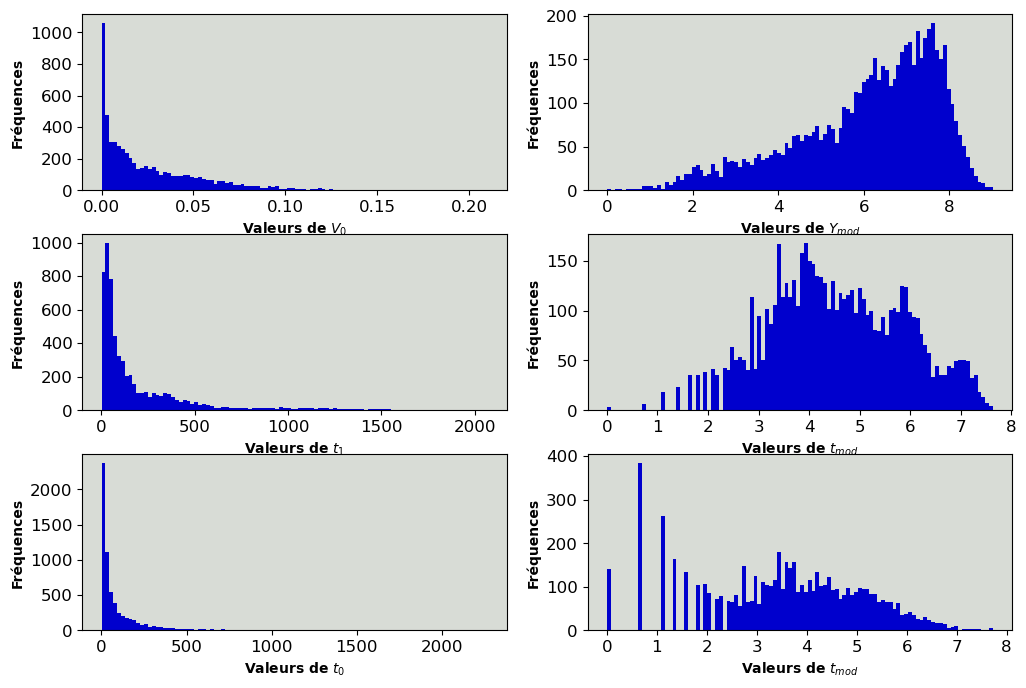

In [62]:
plt.style.use("default")
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(hspace = .25, wspace=.19)
gs1 = gridspec.GridSpec(3, 2)
axs = []

axs.append(fig.add_subplot(gs1[1]))
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')
_=ax.hist(X['Y1'], bins=100, color='mediumblue')
_=plt.xticks(fontsize=12)
_=plt.yticks(fontsize=12)
_=plt.xlabel('Valeurs de $Y_{mod}$', fontweight='bold')
_=plt.ylabel('Fréquences', fontweight='bold')
axs.append(fig.add_subplot(gs1[0]))
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')
_=ax.hist(old_version1, bins=100, color='mediumblue')
_=plt.yticks(fontsize=12)
_=plt.xticks(fontsize=12)
_=plt.xlabel('Valeurs de $V_0$', fontweight='bold')
_=plt.ylabel('Fréquences', fontweight='bold')
axs.append(fig.add_subplot(gs1[3]))
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')
_=ax.hist(X['Y2'], bins=100, color='mediumblue')
_=plt.xticks(fontsize=12)
_=plt.yticks(fontsize=12)
_=plt.xlabel('Valeurs de $t_{mod}$', fontweight='bold')
_=plt.ylabel('Fréquences', fontweight='bold')
axs.append(fig.add_subplot(gs1[2]))
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')
_=ax.hist(old_version2, bins=100, color='mediumblue')
_=plt.yticks(fontsize=12)
_=plt.xticks(fontsize=12)
_=plt.xlabel('Valeurs de $t_1$', fontweight='bold')
_=plt.ylabel('Fréquences', fontweight='bold')
axs.append(fig.add_subplot(gs1[5]))
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')
_=ax.hist(X['Y0'], bins=100, color='mediumblue')
_=plt.xticks(fontsize=12)
_=plt.yticks(fontsize=12)
_=plt.xlabel('Valeurs de $t_{mod}$', fontweight='bold')
_=plt.ylabel('Fréquences', fontweight='bold')
axs.append(fig.add_subplot(gs1[4]))
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')
_=ax.hist(old_version3, bins=100, color='mediumblue')
_=plt.yticks(fontsize=12)
_=plt.xticks(fontsize=12)
_=plt.xlabel('Valeurs de $t_0$', fontweight='bold')
_=plt.ylabel('Fréquences', fontweight='bold')

##### Mise en place de l'entrainement du réseau de neurones

Pour la base d'entrainement, les données sont standardiser afin de réduire les eccarts de valeurs pour les données dites $\textit{inputs}$. C'est à dire que toutes les entrées ont le même ordre de grandeur.<br> On applique enfin cette transformation sur la base de test également.

In [78]:
Train, Test = train_test_split(X[['Pressure', 'Pixels', 'NFace', 'NFace_c', 'Ratio', 'Centre', 'Y0', 'Y1', 'Y2']],
                               train_size=0.80)

XTrain = Train[['Pressure', 'Pixels', 'NFace', 'NFace_c', 'Centre']]
YTrain = Train[['Y0', 'Y1', 'Y2']]
XTest = Test[['Pressure', 'Pixels', 'NFace', 'NFace_c', 'Centre']]
YTest = Test[['Y0', 'Y1', 'Y2']]

scaler = StandardScaler().fit(XTrain)
XTrain = scaler.transform(XTrain)
XTest = scaler.transform(XTest)

mu, sigma = np.mean(YTrain), np.sqrt(np.var(YTrain))

Le réseau se compose des couches suivantes :

- **5** couches cachées avec chacune **80** neurones.
- Après chaque couche cachée, les données sont normalisées avec la couche **BatchNormalization**.
- La couche de sortie possède **2** neurones (1 pour chaque output étudiée), où la fonction 'activation est celle décrite plus haut.

<br>
Il s'est avéré ne pas être utile de rajouter des couches de <b>Dropout</b> afin d'évite l'overfitting lors de l'entrainement. Ce dernier se fait sur 1000 époques.
<br>
La modélisation cherche donc une fonction $f$, qui n'est autre que le réseau de neurones tel que :<br><br>
<center> $log(y_1,y_2, y_3) \sim f(x) \quad \forall x \in \mathbb{R}^6$ </center>

In [90]:
entry_1 = Input(shape=(XTrain.shape[1],))
li = Dense(80, activation=tf.nn.relu,
                         bias_initializer=initializers.RandomNormal(mean=mu[0],stddev=sigma[0]))(entry_1)
li = BatchNormalization()(li)
li = Dense(80, activation=tf.nn.relu,
                         bias_initializer=initializers.RandomNormal(mean=mu[0],stddev=sigma[0]))(li)
li = BatchNormalization()(li)
li = Dense(80, activation=tf.nn.relu,
                         bias_initializer=initializers.RandomNormal(mean=mu[0],stddev=sigma[0]))(li)
li = BatchNormalization()(li)
li = Dense(80, activation=tf.nn.relu,
                         bias_initializer=initializers.RandomNormal(mean=mu[0],stddev=sigma[0]))(li)
li = BatchNormalization()(li)
li = Dense(80, activation=tf.nn.relu,
                         bias_initializer=initializers.RandomNormal(mean=mu[0],stddev=sigma[0]))(li)
li = BatchNormalization()(li)
out_1 = Dense(3, activation=tf.nn.leaky_relu)(li)

model = keras.models.Model(entry_1, out_1)

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])


early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='mse',
            verbose=0,
            patience=1000,
            mode='max',
            restore_best_weights=True)

history = model.fit(np.asarray(XTrain).astype('float64'), np.asarray(YTrain).astype('float64'),
          epochs=1000, validation_data=(np.asarray(XTest).astype('float64'),
                                       np.asarray(YTest).astype('float64')), callbacks=[early_stopping],
                  verbose=1)

#### Validation du modèle entrainé

Le coéfficient de régression $R²$ rend compte de la qualité du modèle pour de nouvelles données à prédire, que le modèle n'a pas eu à traiter dans sa phase d'entrainement.

In [93]:
print("R² score pour le temps initial := %0.4f" % r2_score(YTest.iloc[:, 0], history.model.predict(XTest)[:, 0]))
print("R² score pour la velocité := %0.4f" % r2_score(YTest.iloc[:, 1], history.model.predict(XTest)[:, 1]))
print("R² score pour le temps final := %0.4f" % r2_score(YTest.iloc[:, 2], history.model.predict(XTest)[:, 2]))

R² score pour le temps initial := 0.9603
R² score pour la velocité := 0.9287
R² score pour le temps final := 0.9488


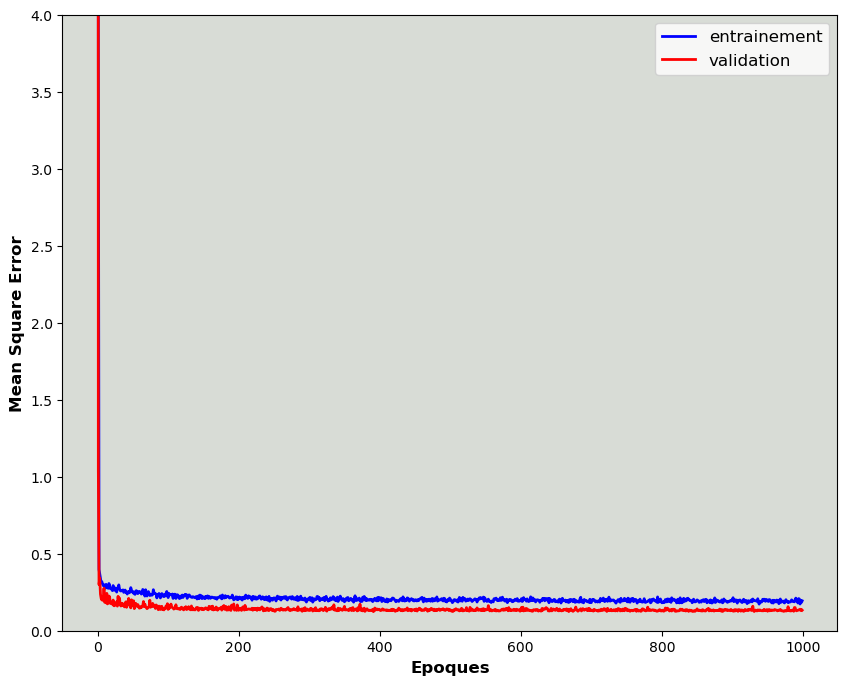

In [84]:
plt.figure(figsize=(10, 8))
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')
plt.plot(history.history['mse'], "b-", lw=2, label="entrainement")
plt.plot(history.history['val_mse'], "r-", lw=2, label="validation")
plt.xlabel('Epoques', fontsize=12, fontweight="bold")
plt.ylabel('Mean Square Error', fontsize=12, fontweight="bold")
plt.legend(loc="upper right", fontsize=12)
plt.ylim(0, 4)
plt.show()

Prédiction du modèle pour la base dite de test pour le logarithme du temps $t_0$.

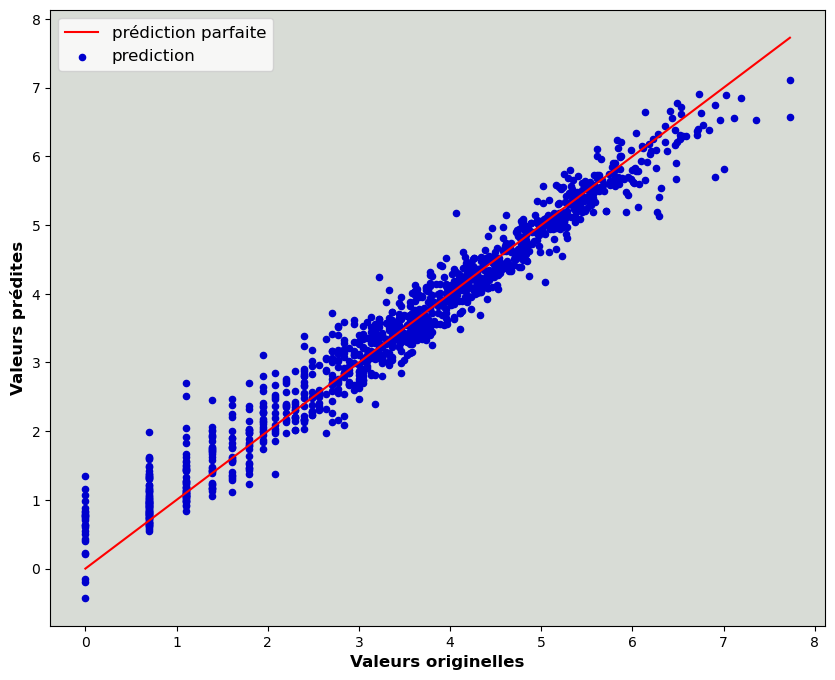

In [87]:
plt.figure(figsize=(10, 8))
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')
plt.scatter(YTest.iloc[:, 0], history.model.predict(XTest)[:, 0], c="mediumblue", s=20,
            label="prediction")
plt.plot([min(YTest.iloc[:, 0]), max(YTest.iloc[:, 0])],
         [min(YTest.iloc[:, 0]), max(YTest.iloc[:, 0])], 'r-',
         label="prédiction parfaite")
plt.xlabel('Valeurs originelles', fontsize=12, fontweight="bold")
plt.ylabel('Valeurs prédites', fontsize=12, fontweight="bold")
plt.legend(loc="upper left", fontsize=12)
plt.show()

Prédiction du modèle pour la base dite de test pour le logarithme de la vitesse $V_0$.

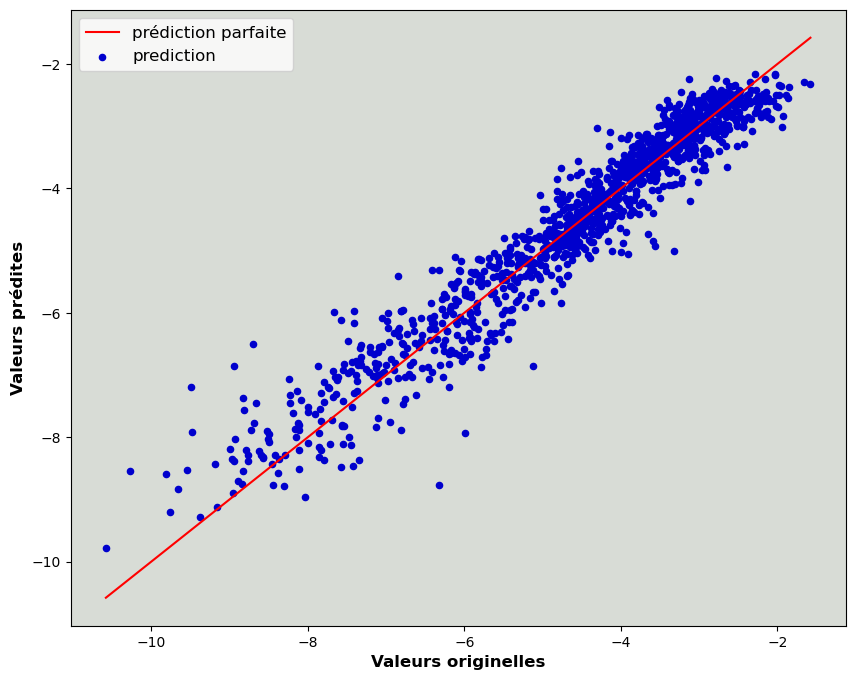

In [88]:
plt.figure(figsize=(10, 8))
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')
plt.scatter(YTest.iloc[:, 1]+minval, history.model.predict(XTest)[:, 1]+minval, c="mediumblue", s=20,
            label="prediction")
plt.plot([min(YTest.iloc[:, 1]+minval), max(YTest.iloc[:, 1]+minval)],
         [min(YTest.iloc[:, 1]+minval), max(YTest.iloc[:, 1]+minval)], 'r-',
         label="prédiction parfaite")
plt.xlabel('Valeurs originelles', fontsize=12, fontweight="bold")
plt.ylabel('Valeurs prédites', fontsize=12, fontweight="bold")
plt.legend(loc="upper left", fontsize=12)
plt.show()

Prédiction du modèle pour la base dite de test pour le logarithme de la vitesse $t_1$.

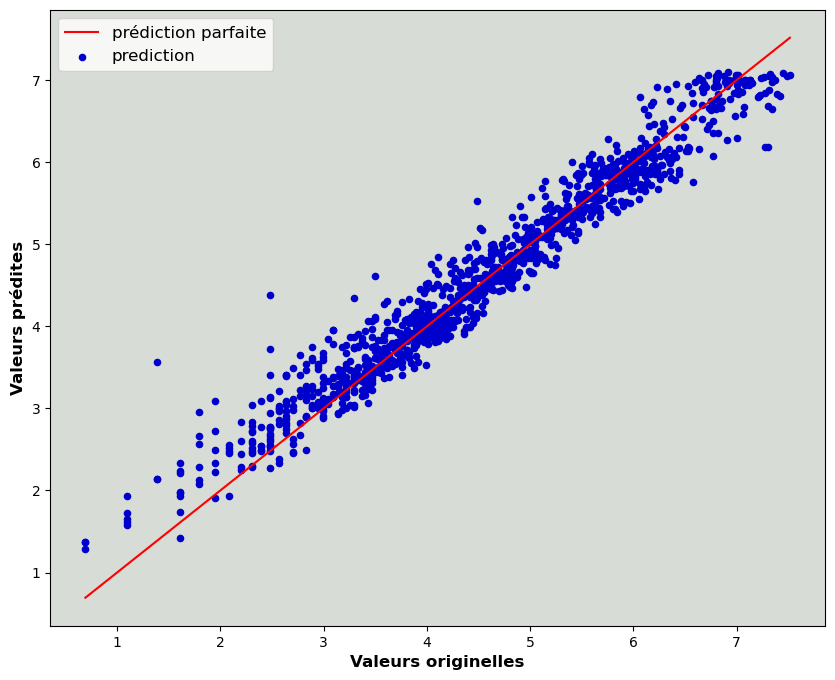

In [89]:
plt.figure(figsize=(10, 8))
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')
plt.scatter(YTest.iloc[:, 2], history.model.predict(XTest)[:, 2], c="mediumblue", s=20,
            label="prediction")
plt.plot([min(YTest.iloc[:, 2]), max(YTest.iloc[:, 2])],
         [min(YTest.iloc[:, 2]), max(YTest.iloc[:, 2])], 'r-',
         label="prédiction parfaite")
plt.xlabel('Valeurs originelles', fontsize=12, fontweight="bold")
plt.ylabel('Valeurs prédites', fontsize=12, fontweight="bold")
plt.legend(loc="upper left", fontsize=12)
plt.show()

##### Analyse de sensitivté

Une analyse de sensitivité du modèle permet de donner la variation de la sortie, en fonction de celle d'une des variables d'entrée du modèle. Pour cela, on utilise les indices de Sobol [[2]](https://tel.archives-ouvertes.fr/tel-01347105/document) :

<center> $S_i := \frac{Var[E(Y|X_i)]}{Var[Y]}$ </center>

<br>
où $i$ représente la $i-ème$ variable d'entrée.

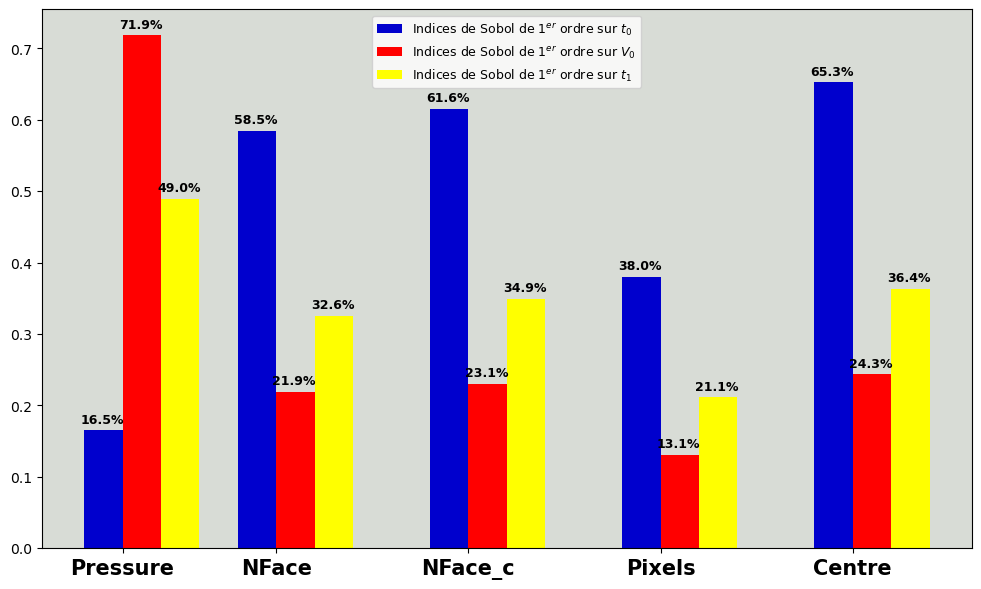

In [112]:
plt.figure(figsize=(12, 7))
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')
var_init = ['Pressure', 'Pixels', 'NFace', 'NFace_c', 'Centre']
plt.bar([i-0.5 for i in [0,5-1,10-1,15-1,20-1]],
        [np.var(Train.groupby(i)['Y0'].mean()) / np.var(Train['Y0']) for i in var_init],
        1, label='Indices de Sobol de $1^{er}$ ordre sur $t_0$', color='mediumblue')
plt.bar([i+0.5 for i in [0,5-1,10-1,15-1,20-1]],
        [np.var(Train.groupby(i)['Y1'].mean()) / np.var(Train['Y1']) for i in var_init],
        1, label='Indices de Sobol de $1^{er}$ ordre sur $V_0$', color='red')
plt.bar([i+1.5 for i in [0,5-1,10-1,15-1,20-1]],
        [np.var(Train.groupby(i)['Y2'].mean()) / np.var(Train['Y2']) for i in var_init],
        1, label='Indices de Sobol de $1^{er}$ ordre sur $t_1$', color='yellow')

for i,j in zip(var_init, [0,5-1,10-1,15-1,20-1]):
    plt.annotate(str(round(np.var(Train.groupby(i)['Y0'].mean()) / np.var(Train['Y0'])*100, 1))+"%",
                 xy=(j-1.1,
                     np.var(Train.groupby(i)['Y0'].mean()) / np.var(Train['Y0'])+0.01),
                 fontweight='bold', color="black", fontsize=9)
    plt.annotate(str(round(np.var(Train.groupby(i)['Y1'].mean()) / np.var(Train['Y1'])*100, 1))+"%",
                 xy=(j-0.1,
                     np.var(Train.groupby(i)['Y1'].mean()) / np.var(Train['Y1'])+0.01),
                 fontweight='bold', color="black", fontsize=9)
    plt.annotate(str(round(np.var(Train.groupby(i)['Y2'].mean()) / np.var(Train['Y2'])*100, 1))+"%",
                 xy=(j+0.9,
                     np.var(Train.groupby(i)['Y2'].mean()) / np.var(Train['Y2'])+0.01),
                 fontweight='bold', color="black", fontsize=9)
_=plt.xticks([0,5-1,10-1,15-1,20-1], labels=['Pressure', "NFace", "NFace_c", "Pixels", "Centre"], fontsize=15,
            fontweight="bold")
_=plt.legend(fontsize=9)

##### Comparaison avec la saturation totale de la structure

A partir de ces données prédites pour une structure, il est possible de comparer une approximation de la saturation totale de la structure en moyennant sur l'ensemble de ses pores, et de pouvoir comparer avec la véritable valeur. Pour ce faire, on utilise l'approximation suivante :
<br><br>
<center> $s := \frac{v_0}{2}\times(t_1-t_0) $</center>
<br><br>
En utilisant les logarithmes prédit, on tente de retrouver la saturation de la strucutre. Au total, il y a 5 structures (une par pression).

In [134]:
real, fake, std = [], [], []

for p in [0.5, 1, 2, 4, 8]:
    toTest = scaler.transform(X[X['Pressure'] == p][['Pressure', 'Pixels', 'NFace', 'NFace_c', 'Centre']])
    
    v0=[np.exp(i+minval) for i in X[X['Pressure'] == p]['Y1']]
    t0=[np.exp(i) for i in X[X['Pressure'] == p]['Y0']]
    t1=[np.exp(i) for i in X[X['Pressure'] == p]['Y2']]
    
    s = [i/2*(j-k) for i,j,k in zip(v0,t1,t0)]
    
    v0_pred=[np.exp(i+minval) for i in history.model.predict(toTest)[:, 1]]
    t0_pred=[np.exp(i) for i in history.model.predict(toTest)[:, 0]]
    t1_pred=[np.exp(i) for i in history.model.predict(toTest)[:, 2]]
             
    s_pred = [i/2*(j-k) for i,j,k in zip(v0_pred,t1_pred,t0_pred)]
    
    real.append(np.mean(s))
    fake.append(np.mean(s_pred))
    std.append(np.sqrt(np.var(s_pred)))

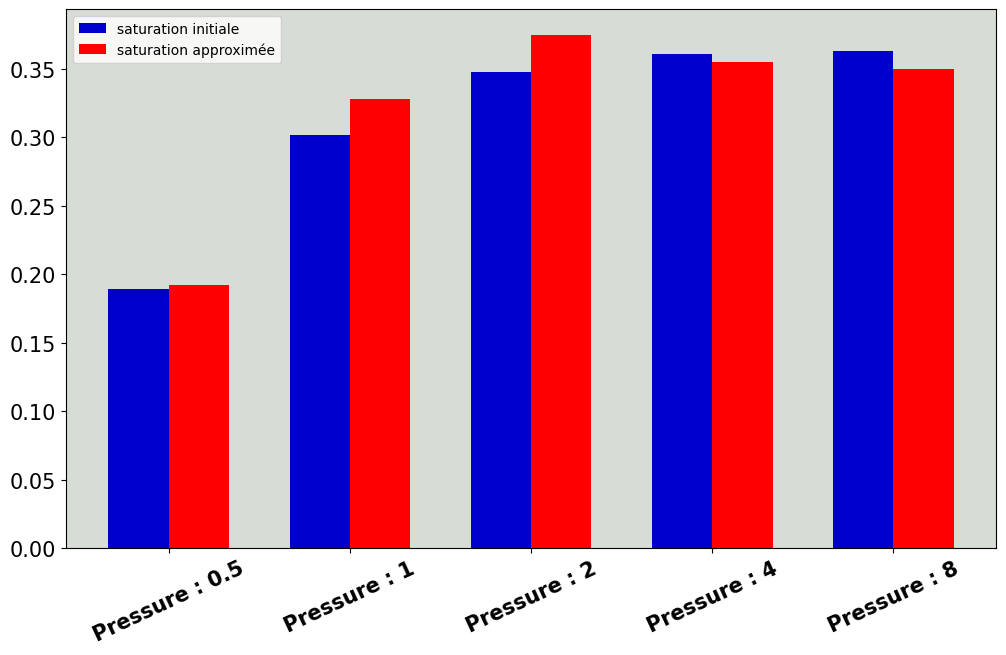

In [137]:
plt.figure(figsize=(12, 7))
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')
var_init = ['Pressure', 'Pixels', 'NFace', 'NFace_c', 'Centre']
plt.bar([1,4,7,10,13], real, width=1, color="mediumblue", label='saturation initiale')
plt.bar([2,5,8,11,14], [0.19194, 0.32805, 0.37504, 0.35525, 0.34987], width=1, color="red",
        label='saturation approximée')
_=plt.xticks([1.5, 4.5, 7.5, 10.5, 13.5], labels=['Pressure : 0.5', "Pressure : 1", "Pressure : 2",
                                             "Pressure : 4", "Pressure : 8"], fontsize=15,
            fontweight="bold", rotation=25)
_=plt.yticks(fontsize=15)
_=plt.legend(fontsize=10)

##### Sauvergarde des ressources nécessaires au modèle

In [114]:
model.save("./ressources/validated_model")

with open('./ressources/scaler.pkl', 'wb') as f:
                pickle.dump(scaler, f)

INFO:tensorflow:Assets written to: ./ressources/validated_model/assets


##### Utiliser le modèle ultérieurement

Afin de pouvoir utiliser le modèle, il est important d'avoir :
- le modèle entrainé.
- la fonction de normalisation des variables d'entrées.
- la valeur minimale de la distribution de la transformation pour la vélocité, afin de prédire la valeur shiftée.

In [193]:
model_to_be_used = tf.keras.models.load_model("./validated_model")
with open('../ressources/scaler.pkl', 'rb') as f:
                scaler = pickle.load(f)